# Bayesian Networks in Python

In this tutorial, we will explore how to use Bayesian networks in Python using the `pgmpy` library.

See documentation at:
- https://pgmpy.org/
- https://pgmpy.org/models/bayesiannetwork.html
- https://pgmpy.org/factors/discrete.html
- https://pgmpy.org/exact_infer/ve.html

## Implementation in Python using `pgmpy`.

Let's start by installing the `pgmpy` library.

In [ ]:
!pip install -q pgmpy networkx matplotlib plotly daft

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 31.8 MB/s eta 0:00:00


Import the required libraries.

In [ ]:
import numpy as np
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
import networkx as nx
import matplotlib.pyplot as plt

Create the Bayesian network:

+---------------+------+
| Infected(no)  | 0.99 |
+---------------+------+
| Infected(yes) | 0.01 |
+---------------+------+
+----------------+--------------+---------------+
| Infected       | Infected(no) | Infected(yes) |
+----------------+--------------+---------------+
| Test(negative) | 0.9          | 0.05          |
+----------------+--------------+---------------+
| Test(positive) | 0.1          | 0.95          |
+----------------+--------------+---------------+


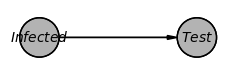

In [ ]:
# Define the network structure
model = BayesianNetwork([('Infected', 'Test')])

statenames = {'Infected': ['no', 'yes'],
              'Test': ['negative', 'positive']}

# Define the probability distribution for 'Infected' (P(Infected))
cpd_infected = TabularCPD(variable='Infected', variable_card=2,
                          state_names=statenames,
                          values=[[0.99], [0.01]])

# Define the conditional probability distribution for 'Test' (P(Test | Infected))
cpd_test = TabularCPD(variable='Test', variable_card=2,
                      state_names=statenames,
                      evidence=['Infected'], evidence_card=[2],
                      values=[[0.9, 0.05],
                              [0.1, 0.95]])

# Add the probability distributions to the model
model.add_cpds(cpd_infected, cpd_test)
model.to_daft(node_pos={"Infected": (0, 0), "Test": (2, 0)}).render()

print(cpd_infected)
print(cpd_test)


With our Bayesian network set up, we can now compute the probability that Peter is infected given his positive test result. 

In [ ]:
# Perform inference
from pgmpy.inference import VariableElimination
inference = VariableElimination(model)
evidence={'Test':'positive'}
result = inference.query(variables=['Infected'], evidence=evidence)
print(evidence)
print(result)

print(inference.query(variables=['Test']))

{'Test': 'positive'}
+---------------+-----------------+
| Infected      |   phi(Infected) |
+===============+=================+
| Infected(no)  |          0.9124 |
+---------------+-----------------+
| Infected(yes) |          0.0876 |
+---------------+-----------------+
+----------------+-------------+
| Test           |   phi(Test) |
+================+=============+
| Test(negative) |      0.8915 |
+----------------+-------------+
| Test(positive) |      0.1085 |
+----------------+-------------+


## Another Example (Alarm)



+-------------+-------+
| Burglary(0) | 0.999 |
+-------------+-------+
| Burglary(1) | 0.001 |
+-------------+-------+
+---------------+-------+
| Earthquake(0) | 0.998 |
+---------------+-------+
| Earthquake(1) | 0.002 |
+---------------+-------+
+------------+---------------+---------------+---------------+---------------+
| Burglary   | Burglary(0)   | Burglary(0)   | Burglary(1)   | Burglary(1)   |
+------------+---------------+---------------+---------------+---------------+
| Earthquake | Earthquake(0) | Earthquake(1) | Earthquake(0) | Earthquake(1) |
+------------+---------------+---------------+---------------+---------------+
| Alarm(0)   | 0.999         | 0.71          | 0.06          | 0.05          |
+------------+---------------+---------------+---------------+---------------+
| Alarm(1)   | 0.001         | 0.29          | 0.94          | 0.95          |
+------------+---------------+---------------+---------------+---------------+
+--------------+----------+----------+


[<TabularCPD representing P(Burglary:2) at 0x7f041ab557e0>,
 <TabularCPD representing P(Earthquake:2) at 0x7f041ab57f70>,
 <TabularCPD representing P(Alarm:2 | Burglary:2, Earthquake:2) at 0x7f041ab57d30>,
 <TabularCPD representing P(JohnCalls:2 | Alarm:2) at 0x7f041ab82800>,
 <TabularCPD representing P(MaryCalls:2 | Alarm:2) at 0x7f041ab82830>]

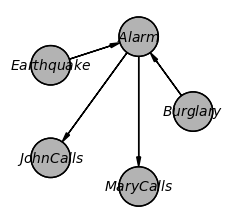

In [ ]:
model = BayesianNetwork([
    ('Burglary', 'Alarm'), 
    ('Earthquake', 'Alarm'), 
    ("Alarm", "JohnCalls"), 
    ("Alarm","MaryCalls")])

model.to_daft().render()

model.add_cpds(
  TabularCPD(
      variable='Burglary', 
      variable_card=2,
      values=[[0.999], [0.001]]),
  TabularCPD(
      variable='Earthquake', 
      variable_card=2,
      values=[[0.998], [0.002]]),
  TabularCPD(
      variable='Alarm', 
      variable_card=2,
      evidence=['Burglary', 'Earthquake'], 
      evidence_card=[2,2],
      values = [[0.999, 0.71, 0.06, 0.05],
                [0.001, 0.29, 0.94, 0.95]]),
  TabularCPD(
      variable='JohnCalls', 
      variable_card=2,
      evidence=['Alarm'], evidence_card=[2],
      values = [[0.95, 0.1],
                [0.05, 0.9]]),
  TabularCPD(
      variable='MaryCalls', 
      variable_card=2,
      evidence=['Alarm'], 
      evidence_card=[2],
      values = [[0.99, 0.3],
                [0.01, 0.7]])
)

model.get_cpds()

In [ ]:
inference = VariableElimination(model)
evidence = {'MaryCalls':1}
result = inference.query(variables=['Burglary'], evidence=evidence)
print("Evidence:",evidence)
print(result)

Evidence: {'MaryCalls': 1}
+-------------+-----------------+
| Burglary    |   phi(Burglary) |
+=============+=================+
| Burglary(0) |          0.9439 |
+-------------+-----------------+
| Burglary(1) |          0.0561 |
+-------------+-----------------+
